In [1]:
import pandas as pd
import plotly.express as px

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
city = df_train.loc[df_train['City'] == 'Atlanta']
intersections = city['IntersectionId'].unique()

Get mean intersection wait times in the 80th percentile

In [9]:
longs = []
lats = []
mean_80_wait = []
for inter in intersections:
    intersection = city.loc[city['IntersectionId'] == inter]
    longs.append(intersection['Longitude'].values[0])
    lats.append(intersection['Latitude'].values[0])
    mean_80_wait.append(intersection['TotalTimeStopped_p80'].values.mean())
df = pd.DataFrame(list(zip(longs, lats,mean_80_wait,intersections)),
               columns =['lon', 'lat','wait','intid'])

In [10]:
fig = px.scatter_mapbox(df, lat="lat", lon="lon",
                        color_discrete_sequence=["black"],size=mean_80_wait, zoom=10, height=400,hover_data=['intid'])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

---

In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train = df_train.fillna('ffill')
df_test = df_test.fillna('ffill')

In [3]:

with open('../data/val_preds.pickle', 'rb') as handle:
    val_preds = pickle.load(handle)

with open('../data/val_labels.pickle', 'rb') as handle:
    val_labels = pickle.load(handle)

In [4]:
# separate labels from features
full_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']


df_train_y = df_train[rel_training_label_cols]

# drop columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+full_training_label_cols)

In [5]:
cities = ['Atlanta','Boston','Chicago','Philadelphia']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

Atlanta, TotalTimeStopped_p20, SSE: 2035776.4847861156
Atlanta, TotalTimeStopped_p50, SSE: 13056161.102781028
Atlanta, TotalTimeStopped_p80, SSE: 35268019.84966039
Atlanta, DistanceToFirstStop_p20, SSE: 29690419.14664948
Atlanta, DistanceToFirstStop_p50, SSE: 390489213.6682247
Atlanta, DistanceToFirstStop_p80, SSE: 3102987100.785468
Boston, TotalTimeStopped_p20, SSE: 3396807.950070947
Boston, TotalTimeStopped_p50, SSE: 14783951.820673037
Boston, TotalTimeStopped_p80, SSE: 51076524.042487
Boston, DistanceToFirstStop_p20, SSE: 29438987.669154555
Boston, DistanceToFirstStop_p50, SSE: 109441984.94701424
Boston, DistanceToFirstStop_p80, SSE: 498337989.7129189
Chicago, TotalTimeStopped_p20, SSE: 1448831.694952045
Chicago, TotalTimeStopped_p50, SSE: 5438383.944035583
Chicago, TotalTimeStopped_p80, SSE: 16024534.541441105
Chicago, DistanceToFirstStop_p20, SSE: 20368098.35001406
Chicago, DistanceToFirstStop_p50, SSE: 74632550.9652857
Chicago, DistanceToFirstStop_p80, SSE: 288312020.2174651
Phil

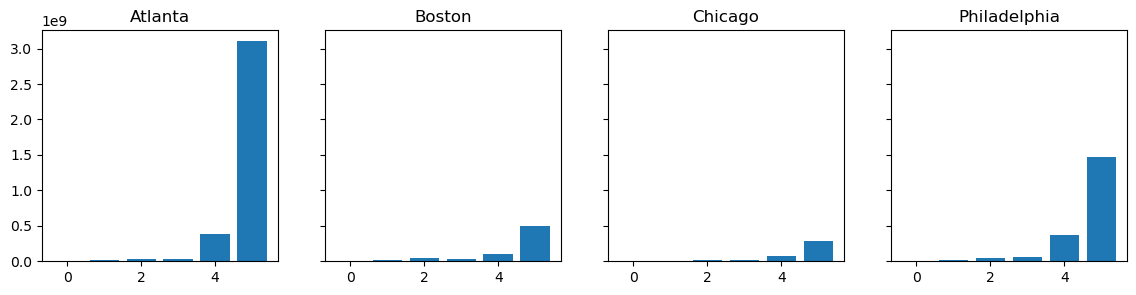

In [6]:
total = 0
cnt = 0
fig,ax = plt.subplots(1,4,sharey=True,figsize=(14,3))
for city_i,city in enumerate(cities):
    errs = []
    names = []
    for target_i,target in enumerate(city_training_datasets_y['Atlanta'].columns):
        err = np.sum(np.square(val_labels[city_i*6+target_i]-val_preds[city_i*6+target_i]))
        errs.append(err)
        names.append(target)
        cnt += len(val_labels[city_i*6+target_i])
        print(f"{city}, {target}, SSE: {err}")
        total += err
    ax[city_i].bar(np.arange(6),errs)
    ax[city_i].set_title(city)
    plt.tight_layout
print(f'Total RMSE: {np.sqrt(total/cnt)}')


next visualize where errors are occuring

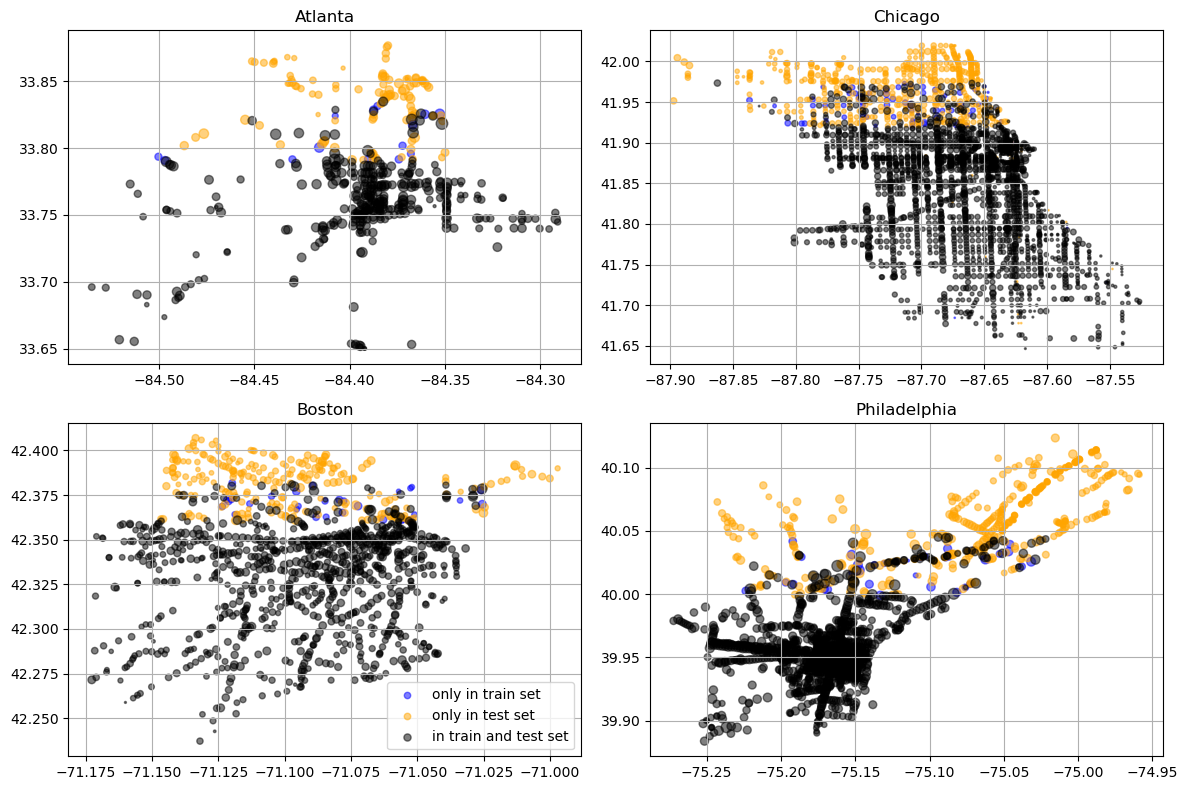

In [8]:
fig,ax = plt.subplots(2,2,figsize=(12,8))

for city_i,city in enumerate(cities):

    with open(f'../data/out_probs_{city}.pickle', 'rb') as handle:
        out_probs = pickle.load(handle)

    # dist_p80
    preds = val_preds[6*city_i+5]
    labels = val_labels[6*city_i+5]
    err = np.abs(preds-labels)

    largest_idxs = np.argsort(out_probs)[-10000:]
    most_test_like = city_training_datasets_X[city].iloc[largest_idxs]

    largest_err_idxs = np.argsort(err)[-1000:]
    larg_err = city_training_datasets_X[city].iloc[largest_err_idxs]

    # get the train and test labeled
    train_points = city_training_datasets_X[city]
    train_points['train'] = 1
    test_points = city_testing_datasets_X[city]
    test_points['test'] = 0
    total = pd.concat([train_points,test_points])

    # get counts per intersection
    counts_per_intersection = total.groupby('IntersectionId').size().reset_index()
    mtl_counts = most_test_like.groupby('IntersectionId').size().reset_index()
    err_counts = larg_err.groupby('IntersectionId').size().reset_index()

    # group by intersection id
    grouped_train = city_training_datasets_X[city].groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    grouped_test = city_testing_datasets_X[city].groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    grouped_all = total.groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()

    grouped_mtl = most_test_like.groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    grouped_err = larg_err.groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    
    # get intersections that are only train
    unique_train_intersection_ids = np.setdiff1d(np.unique(train_points['IntersectionId'].values),np.unique(test_points['IntersectionId'].values))
    unique_train_intersections = grouped_train[grouped_train['IntersectionId'].isin(unique_train_intersection_ids)]
    unique_train_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(unique_train_intersection_ids)].values[:,1]

    unique_mtl_intersection_ids = np.unique(most_test_like['IntersectionId'])
    unique_mtl_intersections = grouped_mtl[grouped_mtl['IntersectionId'].isin(unique_mtl_intersection_ids)]
    unique_mtl_intersection_sizes = mtl_counts[mtl_counts['IntersectionId'].isin(unique_mtl_intersection_ids)].values[:,1]

    unique_err_intersection_ids = np.unique(larg_err['IntersectionId'])
    unique_err_intersections = grouped_err[grouped_err['IntersectionId'].isin(unique_err_intersection_ids)]
    unique_err_intersection_sizes = err_counts[err_counts['IntersectionId'].isin(unique_err_intersection_ids)].values[:,1]

    # get intersections that are only test
    unique_test_intersection_ids = np.setdiff1d(np.unique(test_points['IntersectionId'].values),np.unique(train_points['IntersectionId'].values))
    unique_test_intersections = grouped_test[grouped_test['IntersectionId'].isin(unique_test_intersection_ids)]
    unique_test_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(unique_test_intersection_ids)].values[:,1]

    # get intersections that appear in both
    unique_intersection_ids = np.concatenate([unique_test_intersection_ids,unique_train_intersection_ids])
    nonunique_intersection_ids = np.setdiff1d(np.unique(total['IntersectionId']),unique_intersection_ids)
    nonunique_intersections = grouped_all[grouped_all['IntersectionId'].isin(nonunique_intersection_ids)]
    nonunique_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(nonunique_intersection_ids)].values[:,1]

    # print(unique_train_intersection_sizes.sum())
    # print(unique_test_intersection_sizes.sum())
    # print(nonunique_intersection_sizes.sum())
    # print()

    row = city_i % 2
    col = city_i // 2
    ax[row][col].scatter(unique_train_intersections['Longitude'],unique_train_intersections['Latitude'],c='blue',s=np.sqrt(unique_train_intersection_sizes),
                         alpha=0.5,label='only in train set')
    ax[row][col].scatter(unique_test_intersections['Longitude'],unique_test_intersections['Latitude'],c='orange',s=np.sqrt(unique_test_intersection_sizes),
                         alpha=0.5,label='only in test set')
    ax[row][col].scatter(nonunique_intersections['Longitude'],nonunique_intersections['Latitude'],c='k',s=np.sqrt(nonunique_intersection_sizes),
                         alpha=0.5,label='in train and test set')
    # ax[row][col].scatter(unique_mtl_intersections['Longitude'],unique_mtl_intersections['Latitude'],c='g',s=10,
    #                      alpha=1.0,label='most test like')
    # ax[row][col].scatter(unique_err_intersections['Longitude'],unique_err_intersections['Latitude'],c='r',s=5,
    #                      alpha=1.0,label='largest errors')
    ax[row][col].set_title(city)
    ax[row][col].grid()
ax[1][0].legend()
plt.tight_layout()
fig.savefig('visualize.png')